## This cell imports necessary libraries.
for data handling (pandas), visualization (matplotlib), graph analysis (networkx), text processing (re), and suppresses future warnings using the warnings module.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import re
import seaborn as sns
import mesa
from ipysigma import Sigma
import warnings
import random as rd
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Here we provides a statistical summary of the dataset
It extracts source nodes, target nodes, edge weights, and timestamps—ignoring comment lines and malformed entries. The data is stored in a pandas DataFrame, and Unix timestamps are converted to datetime objects. Finally, it prints a summary of the datetime distribution.


In [2]:
path = 'out.wiki_talk_eu'
source_nodes = []
target_nodes = []
weights = []
timestamps = []

with open(path, "r") as f:
    for line in f:
        if line.startswith('%'):
            continue
        parts = re.split(r'[ \t]+', line.strip())
        if len(parts) != 4:
            continue
        s, t, w, ts = map(int, parts)
        source_nodes.append(s)
        target_nodes.append(t)
        weights.append(w)
        timestamps.append(ts)

df = pd.DataFrame({
    'source_nodes': source_nodes,
    'target_nodes': target_nodes,
    'weights': weights,
    'time_stamps': timestamps
})

df['datetime'] = pd.to_datetime(df['time_stamps'], unit='s')
print(df['datetime'].describe())

count                            58120
mean     2012-03-19 12:21:24.040502272
min                2004-02-29 06:13:39
25%                2009-06-05 16:47:07
50%                2012-11-24 14:59:04
75%                2014-11-07 18:17:10
max                2015-11-23 10:02:21
Name: datetime, dtype: object


## Datetime Summary Analysis

The dataset contains a total of **58,120** interaction records from the Wikipedia talk network. The **earliest recorded interaction** occurred on **February 29, 2004**, while the **latest interaction** took place on **November 23, 2015**, covering over 11 years of communication data. The **average (mean) timestamp** of interactions falls around **March 19, 2012**, indicating that most interactions are concentrated in the middle of the observed time range. The **25th percentile** timestamp is **June 5, 2009**, and the **75th percentile** is **November 7, 2014**, showing that half of the interactions happened between these two dates. The **median timestamp** is **November 24, 2012**, suggesting a fairly symmetric distribution of activity over time. This summary gives a good sense of the dataset’s temporal coverage and density.


## visualizes the data using plots
This cell analyzes the volume of messages exchanged per day in the Wikipedia talk network. It groups the data by the date component of the `datetime` column and counts the number of messages for each day. The result is plotted as a line graph, with the **x-axis representing the date** and the **y-axis showing the number of messages sent on that day**. The plot provides a clear visual representation of message activity trends over time, helping to identify periods of high or low communication. A grid and labels enhance readability, and the figure is sized for better visibility.


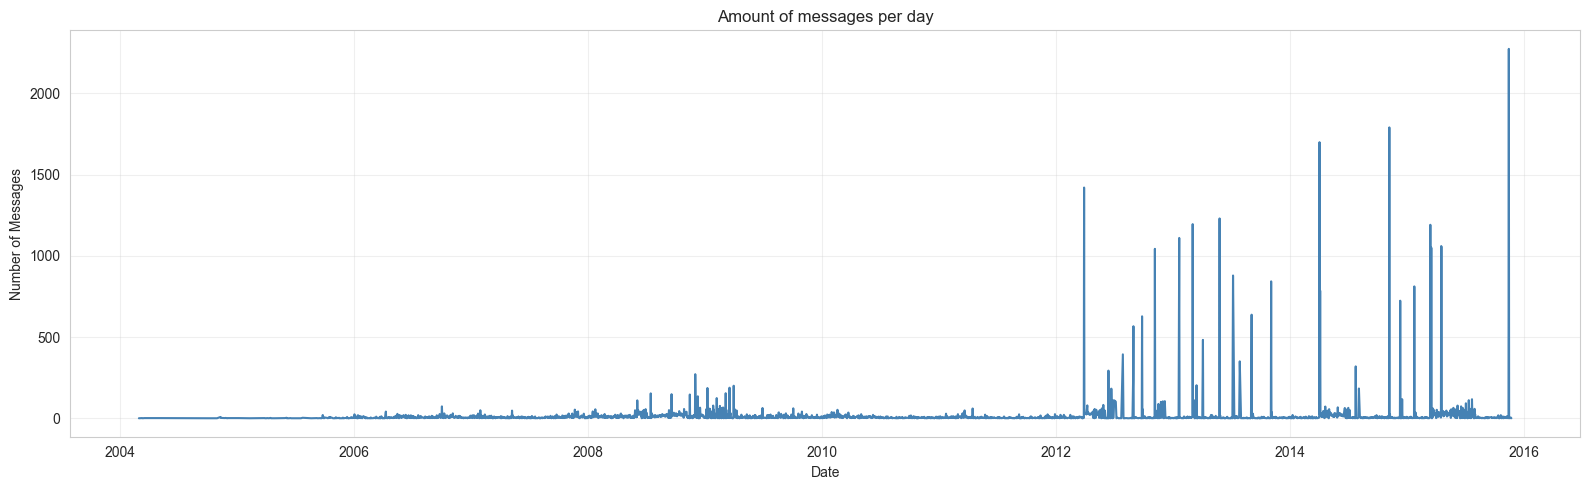

In [3]:
messages_per_day = df.groupby(df['datetime'].dt.date).size()

plt.figure(figsize=(16, 5))
messages_per_day.plot(kind='line', color='steelblue')
plt.title("Amount of messages per day")
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Identifying Top Communicators and Their Interactions

This cell identifies the most active participants in the network. It first calculates the **top 5 senders** (users who initiated the most messages) and the **top 5 receivers** (users who received the most messages) based on frequency counts. Then, it focuses on the **most contacted agent**—the user who received the highest number of messages. The code filters the dataset to include only messages directed to this user and determines which source nodes contacted them the most. This helps reveal communication patterns and highlights key individuals with high inbound message traffic.


In [4]:
top_senders = df['source_nodes'].value_counts().head(5)
print("Top 5 Senders:")
print(top_senders)

top_receivers = df['target_nodes'].value_counts().head(5)
print("\nTop 5 Receivers:")
print(top_receivers)

most_contacted_agent = top_receivers.idxmax()
df_top_received = df[df['target_nodes'] == most_contacted_agent]
contacts_to_top = df_top_received['source_nodes'].value_counts().head(5)

print(f"\nWho contacts Agent {most_contacted_agent} the most:")
print(contacts_to_top)

Top 5 Senders:
source_nodes
469    29478
259     5392
63      2487
22      2461
32      1420
Name: count, dtype: int64

Top 5 Receivers:
target_nodes
22    1612
89    1011
32     808
18     741
19     594
Name: count, dtype: int64

Who contacts Agent 22 the most:
source_nodes
22    245
25    103
63     93
89     84
15     74
Name: count, dtype: int64


## Building a Communication Subgraph of Top Nodes

This cell constructs a directed graph focused on the most active users in the network. It begins by identifying the top 5 senders and receivers, then combines them into a set of unique **top nodes**. The dataset is filtered to include only messages exchanged between these top nodes. Each unique sender–receiver pair is grouped and counted to determine edge weights, which represent the number of messages exchanged. A **directed graph (`DiGraph`)** is then created using NetworkX, where nodes are users and edges are directed messages. Finally, the code calculates **node sizes** based on the number of messages sent by each user, which will be used for visualization purposes—larger nodes indicate more active senders among the top communicators.


In [5]:
top_senders = df['source_nodes'].value_counts().head(5).index
top_receivers = df['target_nodes'].value_counts().head(5).index
top_nodes = set(top_senders).union(top_receivers)

filtered_df = df[df['source_nodes'].isin(top_nodes) & df['target_nodes'].isin(top_nodes)]
filtered_edges = filtered_df.groupby(['source_nodes', 'target_nodes']).size().reset_index(name='weight')

G = nx.DiGraph()
for row in filtered_edges.itertuples(index=False):
    G.add_edge(row.source_nodes, row.target_nodes, weight=row.weight)

sender_counts = filtered_df['source_nodes'].value_counts().to_dict()
node_sizes = [sender_counts.get(n, 1)*0.5 for n in G.nodes()]

## Visualizing the Communication Network of Top Agents

This cell creates a **network graph visualization** of message flows among the top 10 most active agents (senders and receivers). It uses the `kamada_kawai_layout` to position nodes in a visually appealing way based on their connectivity. Nodes represent users and are drawn with sizes proportional to the number of messages they sent, while edges represent the direction and frequency of communication—thicker edges indicate higher message volume. Labels are added to identify each node, and colors and transparency are used to enhance visual clarity. The final plot, titled **"Top 10 agent communication network"**, provides a clear graphical representation of interaction dynamics among the most influential users.


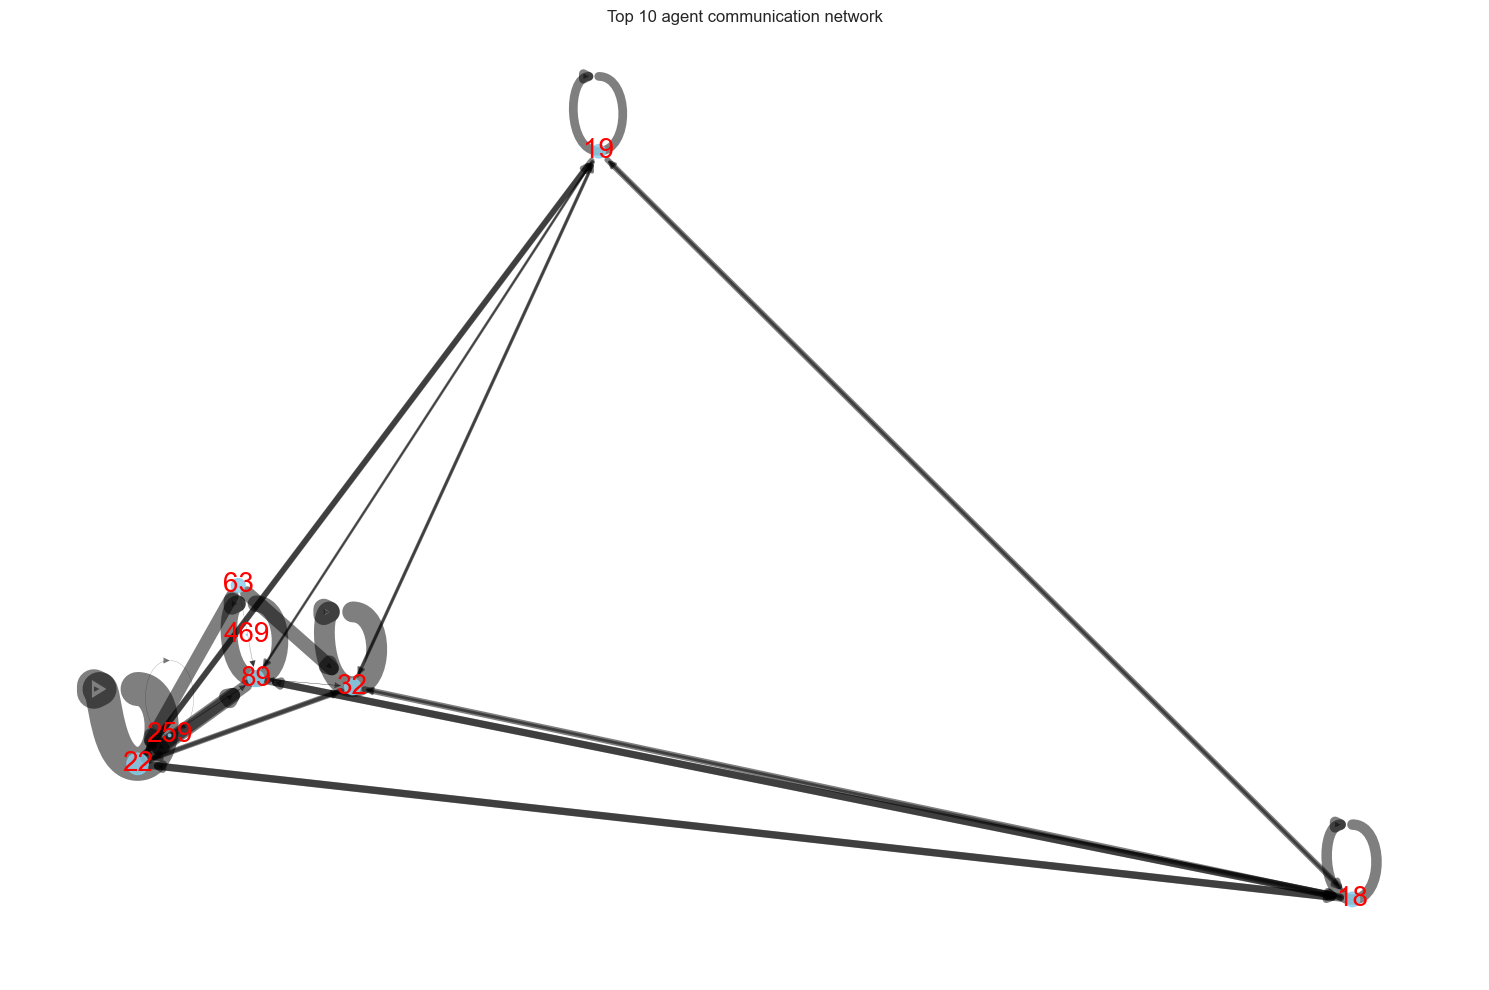

In [6]:
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
edge_widths = [edata['weight'] * 0.1 for _, _, edata in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, arrows=True)

labels = {n: str(n) for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=20, font_color='red')

plt.title("Top 10 agent communication network")
plt.axis('off')
plt.tight_layout()
plt.show()

## Analyzing Monthly Message Trends of Top Agents

This cell tracks the **monthly activity patterns** of the top 5 most active agents based on the number of messages sent. First, it adds a new column to the DataFrame representing the **month** (in `YYYY-MM` format) extracted from the datetime field. Then, it filters the dataset to include only messages sent by the top 5 agents. The data is grouped by both agent and month, counting the number of messages each agent sent per month. This grouped data is visualized in a line plot, where each line represents an agent’s monthly message volume. The plot helps identify trends, spikes, or drops in communication over time for each of the top agents.


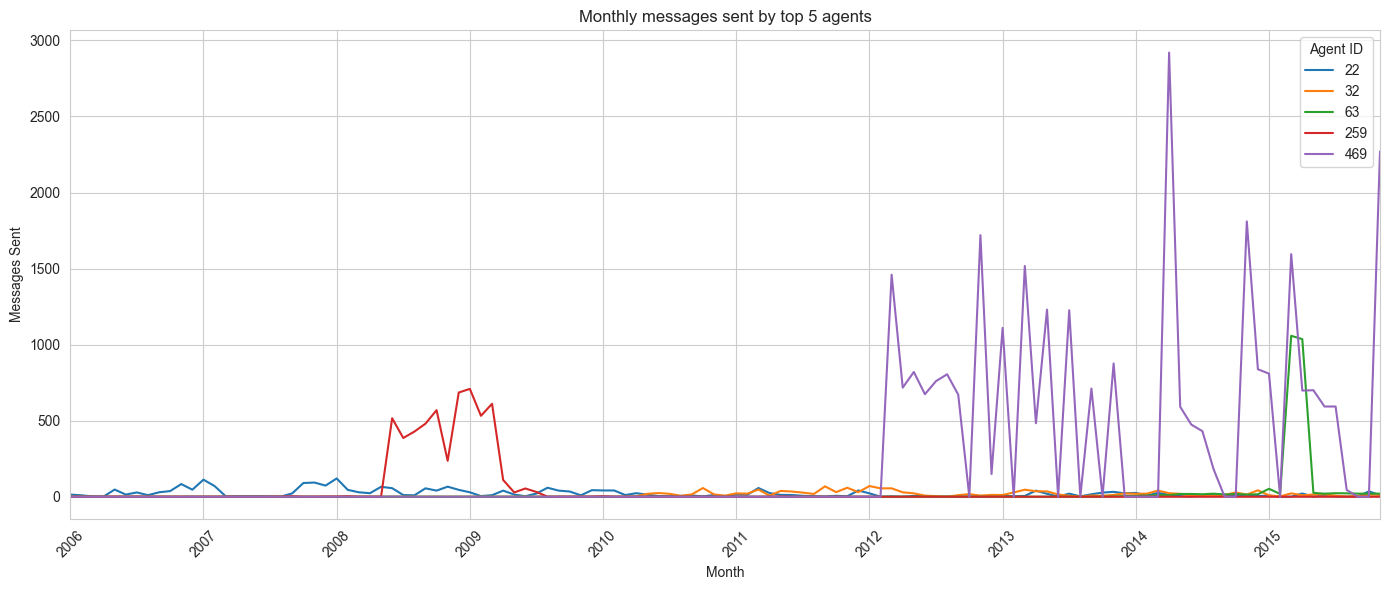

In [7]:
df['month'] = df['datetime'].dt.to_period('M')

top_agents = df['source_nodes'].value_counts().head(5).index
df_top = df[df['source_nodes'].isin(top_agents)]

agent_monthly = df_top.groupby(['source_nodes', 'month']).size().unstack(fill_value=0)
agent_monthly.T.plot(figsize=(14, 6))

plt.title("Monthly messages sent by top 5 agents")
plt.xlabel("Month")
plt.ylabel("Messages Sent")
plt.xticks(rotation=45)
plt.legend(title='Agent ID')
plt.tight_layout()

## Second Part: Computation (MESA) Model

First, some helper functions

In [8]:
# build an adjacency matrix for graph creation
def build_adjacency_matrix(data, max_val):
    ma = np.zeros((max_val, max_val), dtype=np.int8)
    for row in data:
        # off by one, node index starts with 1, so we subtract 1
        ma[(row[0] - 1), (row[1] - 1)] = 1
    return ma


# simple function to get agent states from the model
def get_agent_message_traffic(model):
    tmp_send, tmp_received = [], []
    for agent in model.agents:
        tmp_send.append(agent.message_send)
        tmp_received.append(agent.message_received)

    return np.array([tmp_send, tmp_received])


# simple functino to get Believes out of the system
def get_agent_believes(model):
    believes = []
    for agent in model.agents:
        believes.append(agent.believe)
    return np.array(believes)


# we need to normalise the time and make timesteps smaller, let's use 100 as a scale factor
def setup_time(time_list):
    min_l = min(time_list)
    # normalise time
    time_list = [x - min_l for x in time_list]
    time_list = [round((x / 100)) for x in time_list]
    return time_list


# this function formats our pandas frame for printing and further usage
def formatting(data_frame):
    tmp_list = data_frame.iloc[0][0].tolist()
    return tmp_list

Lets build our graphs, for that we need the source data again:

In [9]:
path = 'out.wiki_talk_eu'
source_nodes = []
target_nodes = []
weights = []
time_stamps = []
raw_data = []
try:
    with open(path, "r") as f:
        for line in f:
            # See the data format we have, each entry in a number (int) and is seperated by a space.
            # We split the string and convert all data to int.
            l_temp = line.strip()
            da = re.split(' |\t', l_temp)
            # skip the first line
            if da[0] == '%':
                continue
            da = [int(x) for x in da]
            # we add all data to their lists, we can easily generate a pandas dataframe or numpy array from it
            raw_data.append(da)
            source_nodes.append(da[0])
            target_nodes.append(da[1])
            weights.append(da[2])
            time_stamps.append(da[3])

        # generating pandas dataframe
        df = pd.DataFrame()
        df['source_nodes'] = source_nodes
        df['target_nodes'] = target_nodes
        df['weights'] = weights
        df['time_stamps'] = setup_time(time_stamps)
        # normalizing time to 0 to max value
        global_max = max(df['source_nodes'].max(), df['target_nodes'].max())
        matrix = build_adjacency_matrix(raw_data, global_max)

        # feedback to understand how the data looks
        print(df.head())
        # and the numpy array looks like that:
        print("Numpy array with the same data:")
        print(matrix)

        # we also want the edges for our directed graph:
        edges_list = []
        for row in raw_data:
            edges_list.append((row[0], row[1]))

except FileNotFoundError:
    print("File not found")

   source_nodes  target_nodes  weights  time_stamps
0             1             2        1            0
1             1             3        1         8850
2             1             3        1         8850
3             3             3        1        10914
4             1             1        1        15097
Numpy array with the same data:
[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Now let us design our grpah for the MESA Usage and for information:

In [10]:
DG = nx.DiGraph()
DG.add_edges_from(edges_list)
print(DG)
Sigma(DG,
      node_color="black",
      node_label_size=DG.degree,
      node_size=DG.degree
      )

DiGraph with 40993 nodes and 46524 edges


Sigma(nx.DiGraph with 40,993 nodes and 46,524 edges)

These are alternative Models for faster runs but without agent functionality. These are mainly for EDA

In [11]:
# This is a model which saves everything in 8 matrices with the size of 41k*41k this takes a lot of memory!!!!
def full_np_fill_model(size, data_frame):
    time_slot_index = 0
    custom_data = []
    report_ma = np.zeros(shape=(size, size), dtype=np.uint8)
    for time_step in range(0, data_frame['time_stamps'].iloc[-1]):
        # multiple messages may happen during a timestep
        while time_step == data_frame['time_stamps'].iloc[time_slot_index]:
            report_ma[(data_frame['source_nodes'].iloc[time_slot_index]), (
            data_frame['target_nodes'].iloc[time_slot_index])] += 1
            time_slot_index += 1
        # every 500k steps we save our matrix
        if time_step % 500000 == 0 and time_step != 0:
            #print(f"Current time step is {time_step}")
            custom_data.append(np.copy(report_ma))

    return custom_data


# This model is faster and return data differently
def action_only_model(size, data_frame):
    custom_data = []
    sender_ma_fast, receiver_ma_fast = np.zeros(size), np.zeros(size)

    for time_step in range(0, data_frame.shape[0]):
        sender_ma_fast[data_frame['source_nodes'].iloc[time_step] - 1] += 1
        receiver_ma_fast[data_frame['target_nodes'].iloc[time_step] - 1] += 1

        if time_step % 10000 == 0 and time_step != 0:
            #print(f"Current time step is {time_step}")
            custom_data.append([np.copy(sender_ma_fast), np.copy(receiver_ma_fast)])
    custom_data.append([np.copy(sender_ma_fast), np.copy(receiver_ma_fast)])
    return custom_data

Next our Wiki Agent Class:

In [12]:
class Wiki_Agent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)

        # Define the threshold, initialise Neighbours, state at 0
        # as we need a variable threshold we will not set it here
        self.threshold = 0
        self.neighbours = []
        self.message_send = 0
        self.message_received = 0

        # RQ1 stats:
        self.trust = 0
        self.believe = rd.choice([1, -1])

    # RQ one: trust threshold
    def set_trust(self, trust_baseline, agents, graph):
        self.trust = trust_baseline
        tmp = list(graph.neighbors(self.unique_id - 1))
        for i in tmp:
            self.neighbours.append(agents[i - 1])

    # RQ one change of believe
    def change_believe(self, agents, agent_pool, m_chance):
        # Change of Believe happens when people meet/talk, neighbours or earlier correspondents
        # have a higher impact as we trust them more

        # we sometimes just change Believe (we have 40k agents, this fastens the run)
        # we take roughly 20%
        if rd.randint(1, 100) > (100 - m_chance):
            believes = []
            for n in agent_pool:
                tmp = 0
                for x in self.neighbours:
                    if x.unique_id == agents[n].unique_id:
                        tmp = agents[n].believe / self.trust
                if tmp == 0:
                    tmp = agents[n].believe
                believes.append(tmp)

            if sum(believes) > 0:
                self.believe = 1
            else:
                self.believe = -1
        else:
            # sometimes we change our mind
            if rd.randint(1, 100) > 99:
                self.believe = self.believe * (-1)

        #print(f"Believe was changed after a meeting to {self.believe}")

    # If an agent doesn't have neighbours, get him some.
    def set_neighbours(self, agents, graph):
        # graphs ids are 1 lower than agent ids, let's deal with it
        # as this is a directed graph we get the neighbour edges lead to!
        tmp = list(graph.neighbors(self.unique_id))
        for i in tmp:
            self.neighbours.append(agents[i - 1])

    # Add a message received to the agent
    def receive_message(self, r_id):
        if self.unique_id == r_id:
            self.message_received += 1

    def send_message(self, s_id):
        if self.unique_id == s_id:
            self.message_send += 1

    def send_all(self):
        for n in self.neighbours:
            self.message_send += 1
            n.message_received += 1

Followed by our complete Model:

In [13]:
class Wiki_Model(mesa.Model):
    # Standard World model with some initial settings:
    # agents = number of nodes our network has
    # graph = connection structure with connection information
    # timeline = what happens when, it's our pandas frame from the initial data preparation
    # Bias for research Q#1 -> how much more is an agent trusted after sending messages with him
    # data collector for output, currently gets messages send and received

    def __init__(self, agents, graph, timeline, data_collector, seed=None):
        super().__init__(seed=seed)
        self.num_agents = agents
        self.graph = graph
        self.timeline = timeline
        self.datacollector = data_collector
        # Create agents
        Wiki_Agent.create_agents(model=self, n=agents)

    def reset_data_collector(self, dc):
        self.datacollector = dc

    def step_slow(self, sender, receiver):
        self.agents.shuffle_do("send_message", sender)
        self.agents.shuffle_do("receive_message", receiver)

    def step(self):
        self.agents.shuffle_do("send_all")

    def believe_step(self, m_chance, agent_pool_size):
        sample_list = rd.sample(range(1, self.num_agents), agent_pool_size)
        self.agents.shuffle_do("change_believe", self.agents, sample_list, m_chance)

    def state_report(self):
        self.datacollector.collect(self)

    def initialize(self):
        # Build the neighbourhood
        self.agents.shuffle_do("set_neighbours", self.agents, self.graph)

    def trust_initialize(self, trust_baseline):
        self.agents.shuffle_do("set_trust", trust_baseline, self.agents, self.graph)

Global(for all models) Hyperparameters:

In [14]:
model_agents = global_max
active_df = df.sort_values(by=['time_stamps'], ascending=True)
max_time = active_df.shape[0]

These are the simple model with simple Printouts:

In [15]:
print(f"maximum time is {active_df['time_stamps'].iloc[-1]} ")
# we run this in real time so we actually progress in time and look if at that time something happens
# THIS TAKES A LOT OF MEMORY!!!!!!!
#custom_data_big_slow = full_np_fill_model(df['target_nodes'].max(), active_df)

# this is the lower memory variant that doesn't really use a timeline but fakes it
custom_data_fast = action_only_model(df['target_nodes'].max(), active_df)
print(custom_data_fast[0])

maximum time is 3702377 
[array([51.,  0.,  3., ...,  0.,  0.,  0.], shape=(40993,)), array([40.,  1.,  3., ...,  0.,  0.,  0.], shape=(40993,))]


This is the standard MESA Model, we ignore time as a vector as this doesn't make real sense with agents all at once:

In [16]:
data_collector_basic = mesa.DataCollector(model_reporters={"Messages": get_agent_message_traffic})
standard_model = Wiki_Model(model_agents, DG, active_df, data_collector_basic)

# set up neighbours of nodes
standard_model.initialize()

# clean up old data
standard_model.reset_data_collector(data_collector_basic)

# we instantly do everything to prepare the model for future work:
for steps in range(1):
    standard_model.step()
    # after we're finished, we get one last report
standard_model.state_report()

## Visualizations:
here  we produce some basic visualisations of the model

First our custom model:

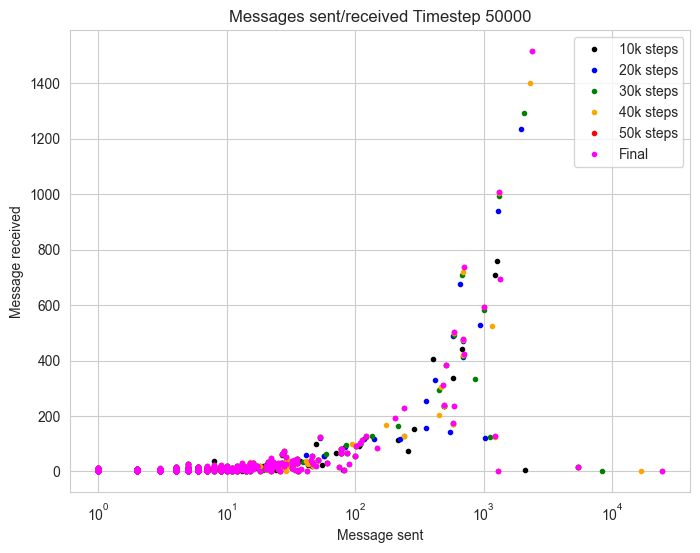

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(custom_data_fast[0][0], custom_data_fast[0][1], marker='.', linestyle='none', color='black', label='10k steps')
plt.plot(custom_data_fast[1][0], custom_data_fast[1][1], marker='.', linestyle='none', color='blue', label='20k steps')
plt.plot(custom_data_fast[2][0], custom_data_fast[2][1], marker='.', linestyle='none', color='green', label='30k steps')
plt.plot(custom_data_fast[3][0], custom_data_fast[3][1], marker='.', linestyle='none', color='orange',
         label='40k steps')
plt.plot(custom_data_fast[4][0], custom_data_fast[4][1], marker='.', linestyle='none', color='red', label='50k steps')
plt.plot(custom_data_fast[4][0], custom_data_fast[4][1], marker='.', linestyle='none', color='magenta', label='Final')

plt.title('Messages sent/received Timestep 50000')
plt.xlabel('Message sent')
plt.ylabel('Message received')
plt.semilogx()
plt.grid(True)
plt.legend()
plt.show()

Followed by the simple MESA Model

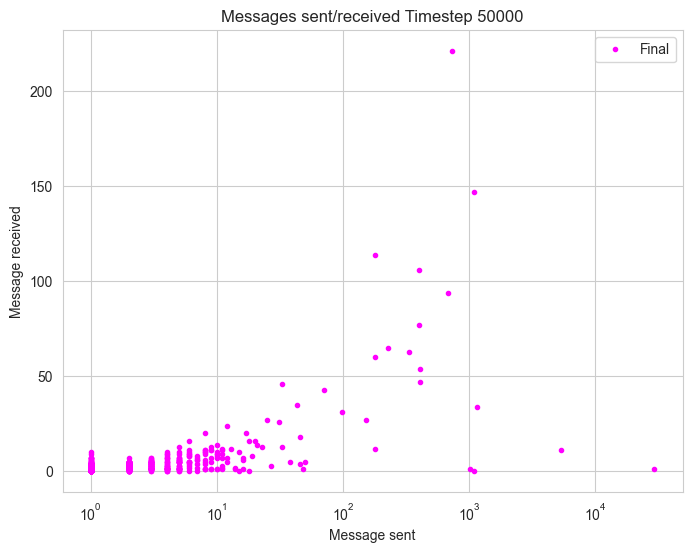

In [18]:
raw_runtime_data = standard_model.datacollector.get_model_vars_dataframe()
format_data = formatting(raw_runtime_data)

plt.figure(figsize=(8, 6))
plt.plot(format_data[0], format_data[1], marker='.', linestyle='none', color='magenta', label='Final')

plt.title('Messages sent/received Timestep 50000')
plt.xlabel('Message sent')
plt.ylabel('Message received')
plt.grid(True)
plt.legend()
plt.semilogx()
plt.show()

And now we start with the Consent research model:

RQ1 Trust and Believe: Agents meet up and talk with each other every timestep. Everyone talks about a big decision to make. Everyone has a specific Believe and gets his chance to change the views of a random sample of n agents. After n steps, a majority voting is done. We also trust agents more we corresponded before.
<br>
We have a trust variable, which is a divisor. If it is between 1 and 0, it increases the value we take from believes we trust:

In [26]:
model_agents = global_max
active_df = df.sort_values(by=['time_stamps'], ascending=True)
max_time = active_df.shape[0]
# trust is inverse, we divide through it, near 1 follows higher trust
trust = 0.1
# define meeting size of models
meeting_size = 20
# Chance in per cent to meet
meeting_chance = 20

run_length = 5
# we need the undirected graph for this
UDG = nx.from_numpy_array(matrix)

THis is the rq1 main model, we define our datacollector, initialize our network, and run the loop. We get a pd frame with 6 entries were each agent has either 1 or -1 as believe, inxdex is also the agent ID for further work

In [20]:
data_collector_rq1 = mesa.DataCollector(model_reporters={"Messages": get_agent_believes})
rq1_model = Wiki_Model(model_agents, UDG, active_df, data_collector_rq1)

# set up neighbours of nodes
rq1_model.trust_initialize(trust)

# clean up old data
rq1_model.reset_data_collector(data_collector_rq1)

# we instantly do everything to prepare the model for future work:
for steps in range(run_length):
    print(f"current time step is {steps}")
    rq1_model.state_report()
    rq1_model.believe_step(meeting_chance, meeting_size)

    # We parse current happenings out every step
rq1_model.state_report()

current time step is 0
current time step is 1
current time step is 2
current time step is 3
current time step is 4


Now to generate Output:

In [21]:
raw_believe_data = rq1_model.datacollector.get_model_vars_dataframe()
print(raw_believe_data)
# we write the file to pickle as simulation runs last quite a while, and we may want to tune hyperparameters
filename = "./data_rq1_" + str(run_length) + "_" + str(trust) + "_" + str(meeting_size) + "_" + str(
    meeting_chance) + "_" + ".pkl"
raw_believe_data.to_pickle(filename)

                                            Messages
0  [1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1,...
1  [1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1...
2  [1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1...
3  [1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1...
4  [1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1,...
5  [1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1...


We may want to access other older runs too:
<br> This is a complicated Dataloader, we can also load old files but we need to cosntruct a pd frame for good visualisations

In [37]:
data_load = True
data_current = True
formatted_believe_data, trusts = [], []
# We have data in a pkl file!
filename_load = "data_rq1_5_0.5_20_20_.pkl"
if data_load:
    read_believe_data = pd.read_pickle(filename_load)
    for i in range(0, run_length + 1):
        tmp = read_believe_data.iloc[i][0].tolist()
        formatted_believe_data.append([tmp.count(1), tmp.count(-1)])
        trusts.append(0.5)

# We also have currently computed data (both!)
if data_current:
    for i in range(0, run_length + 1):
        tmp = raw_believe_data.iloc[i][0].tolist()
        formatted_believe_data.append([tmp.count(1), tmp.count(-1)])
        trusts.append(0.1)

pop_agents = [469,259,102,63]
for agent in pop_agents:
    print(f" Our most influent agent number {agent} believe: \n First iteration: {raw_believe_data.iloc[0][0][agent+1]}")
    print(f"Second Iteration: {raw_believe_data.iloc[1][0][agent+1]}")
    print(f"Third Iteration: {raw_believe_data.iloc[2][0][agent+1]} ")
    print(f"Forth Iteration: {raw_believe_data.iloc[3][0][agent+1]}")
    print(f"Fifth Iteration: {raw_believe_data.iloc[4][0][agent+1]}")
    print(f"Sixth Iteration: {raw_believe_data.iloc[5][0][agent+1]}")

 Our most influent agent number 469 believe: 
 First iteration: 1
Second Iteration: 1
Third Iteration: 1 
Forth Iteration: 1
Fifth Iteration: 1
Sixth Iteration: 1
 Our most influent agent number 259 believe: 
 First iteration: -1
Second Iteration: -1
Third Iteration: -1 
Forth Iteration: -1
Fifth Iteration: 1
Sixth Iteration: 1
 Our most influent agent number 102 believe: 
 First iteration: -1
Second Iteration: -1
Third Iteration: -1 
Forth Iteration: -1
Fifth Iteration: -1
Sixth Iteration: -1
 Our most influent agent number 63 believe: 
 First iteration: -1
Second Iteration: -1
Third Iteration: -1 
Forth Iteration: -1
Fifth Iteration: 1
Sixth Iteration: 1


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    Believer  Nonbeliever  Iteration  Trust
0      20435        20558          0    0.5
1      18513        22480          1    0.5
2      23154        17839          2    0.5
3      26522        14471          3    0.5
4      28938        12055          4    0.5
5      30624        10369          5    0.5
6      20472        20521          0    0.1
7      24689        16304          1    0.1
8      27936        13057          2    0.1
9      30436        10557          3    0.1
10     32420         8573          4    0.1
11     33955         7038          5    0.1


<Axes: xlabel='Iteration', ylabel='Believer'>

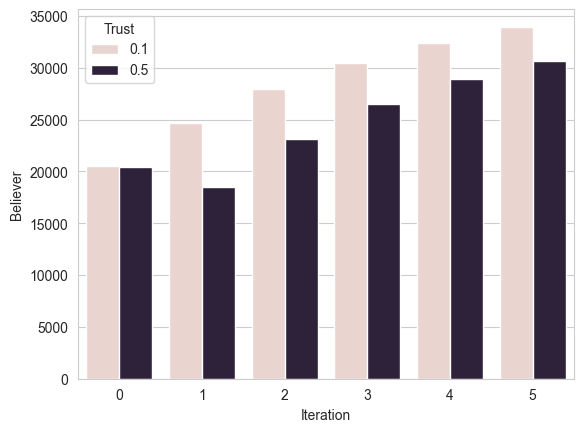

In [35]:
format_df = pd.DataFrame(formatted_believe_data)
format_df.rename({0: 'Believer', 1: 'Nonbeliever'}, axis=1, inplace=True)
format_df['Iteration'] = list(range((run_length+1))) + list(range((run_length+1)))
print(trusts)
format_df['Trust'] = trusts
print(format_df)
sns.barplot(format_df, x="Iteration", y="Believer", hue="Trust")

List of high degree nodes and their believes:

In [39]:
max_deg = 50
nodes_with_high_degree = [node for node, degree in UDG.degree() if degree > max_deg]

for node in nodes_with_high_degree:
    print(f"Hello, I'm agent {node} and my Believe is {raw_believe_data.iloc[1][0][node+1]}")


Hello, I'm agent 8 and my Believe is 1
Hello, I'm agent 10 and my Believe is 1
Hello, I'm agent 14 and my Believe is 1
Hello, I'm agent 16 and my Believe is 1
Hello, I'm agent 17 and my Believe is -1
Hello, I'm agent 18 and my Believe is 1
Hello, I'm agent 19 and my Believe is 1
Hello, I'm agent 21 and my Believe is 1
Hello, I'm agent 22 and my Believe is 1
Hello, I'm agent 23 and my Believe is 1
Hello, I'm agent 24 and my Believe is 1
Hello, I'm agent 31 and my Believe is 1
Hello, I'm agent 35 and my Believe is 1
Hello, I'm agent 62 and my Believe is 1
Hello, I'm agent 74 and my Believe is 1
Hello, I'm agent 78 and my Believe is -1
Hello, I'm agent 88 and my Believe is -1
Hello, I'm agent 101 and my Believe is -1
Hello, I'm agent 150 and my Believe is 1
Hello, I'm agent 166 and my Believe is -1
Hello, I'm agent 258 and my Believe is 1
Hello, I'm agent 325 and my Believe is 1
Hello, I'm agent 468 and my Believe is -1
